In [1]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from plotly.subplots import make_subplots
import numpy as np
import sympy as sy
import pandas as pd
import IPython
from IPython.display import display
import matplotlib.pyplot as plt

def displayH(a1,a2='', a3='', a4='', a5='', a6='', a7='',):
    latex_a1 = sy.latex(a1)
    latex_a2 = sy.latex(a2)
    latex_a3 = sy.latex(a3)
    latex_a4 = sy.latex(a4)
    latex_a5 = sy.latex(a5)
    latex_a6 = sy.latex(a6)
    latex_a7 = sy.latex(a7)
    display( IPython.core.display.Math(latex_a1 + latex_a2 + latex_a3 + latex_a4 + latex_a5 + latex_a6 + latex_a7)  )

# 1. Attitude Reorientation Maneuver Using Reaction Wheels (40 pts)

The spacecraft orbiting Earth (gravitational parameter, $\mu = 398600.4418 \, \text{km}^3/\text{s}^2$), has the following Earth-Centered-Inertial (ECI) position and velocity vectors at the initial time $t_0$:

$$
\mathbf{r}(t_0) = \begin{bmatrix} 7022.743 \\ 6699.3496 \\ 3.7886 \end{bmatrix} \, \text{km}, \quad \mathbf{r}'(t_0) = \begin{bmatrix} -6.2119 \\ 0.9524 \\ 4.3946 \end{bmatrix} \, \text{km/s}
$$

The spacecraft's moment of inertia matrix is:

$$
\mathbf{I} = \begin{bmatrix} 6400 & -76.4 & -25.6 \\ -76.4 & 4730 & -40 \\ -25.6 & -40 & 8160 \end{bmatrix} \, \text{kg-m}^2.
$$

The initial orientation of the spacecraft with respect to the ECI frame is defined by the quaternion vector,

$$
\mathbf{q}(t_0) = \frac{\mathbf{z}_0}{\lVert \mathbf{z}_0 \rVert}, \quad \mathbf{z}_0 = \begin{bmatrix} 0.685 & 0.695 & 0.153 & 0.153 \end{bmatrix}^T
$$

**Note:** The quaternion $\mathbf{q}$ has its scalar component as the fourth entry.  
The spacecraft's initial angular velocity is:

$$
\mathbf{\omega}(t_0) = \begin{bmatrix} 0.53 & 0.53 & 0.053 \end{bmatrix}^\top \, \text{deg/s}
$$

**Note:** The units are given in $\text{deg/s}$ and must be converted to $\text{rad/s}$ for analysis. Additionally, the $\omega_z$ component is smaller than $\omega_x$ and $\omega_y$ by a factor of 10.

At $t_0$, the reaction wheels are not spinning; therefore, the initial wheel momentum is $\mathbf{h}_w(t_0) = \begin{bmatrix} 0 & 0 & 0 \end{bmatrix}^T$. The commanded (desired) quaternion is the identity quaternion,

$$
\mathbf{q} = \begin{bmatrix} 0 & 0 & 0 & 1 \end{bmatrix}^T.
$$

In addition to achieving the commanded quaternion, it is desired that the spacecraft come to a complete stop, i.e., the final angular velocity and the commanded quaternion should be $\mathbf{\omega}_c = \begin{bmatrix} 0 & 0 & 0 \end{bmatrix}^T \, \text{rad/s}$. For this purpose, the following quaternion-based proportional-derivative control law needs to be tested:

$$
\mathbf{L}_{rw} = -k_p \text{sign}(\delta q_4) \delta \mathbf{q}_{1:3} - k_d \mathbf{\omega}
$$

where:

- $\mathbf{L}_{rw}$ = control torque on the spacecraft due to reaction wheels  
- $k_p = 50$, the proportional control gain  
- $k_d = 150$, the derivative control gain  
- $\delta \mathbf{\omega} = \mathbf{\omega} - \mathbf{\omega}_c$, is the angular velocity error  
- $\delta \mathbf{q} = \begin{bmatrix} \delta q_1 & \delta q_2 & \delta q_3 & \delta q_4 \end{bmatrix}^T$, is the quaternion error

Error $\delta \mathbf{q}$ between any quaternion $\mathbf{q}$ and the commanded quaternion $\mathbf{q}_c$ can be found as follows:

$$
\delta q_{1:3} = [\Sigma(\mathbf{q}_c)]^T \mathbf{q}
$$

$$
\delta q_4 = \mathbf{q}_c^T \mathbf{q}
$$

where the matrix $\Sigma(\tilde{\mathbf{q}})$ is:

$$
\Sigma(\tilde{\mathbf{q}}) = 
\begin{bmatrix}
\tilde{q}_4 & -\tilde{q}_3 & \tilde{q}_2 \\
\tilde{q}_3 & \tilde{q}_4 & -\tilde{q}_1 \\
-\tilde{q}_2 & \tilde{q}_1 & \tilde{q}_4 \\
-\tilde{q}_1 & -\tilde{q}_2 & -\tilde{q}_3
\end{bmatrix}
$$

for a generic quaternion $\tilde{\mathbf{q}} = [\tilde{q}_1 \, \tilde{q}_2 \, \tilde{q}_3 \, \tilde{q}_4]^T$.

### Perform the following tasks:

In [2]:
mu = 398600.4418

rECI_0 = np.array([7022.743,6699.3496,3.7886])
vECI_0 = np.array([-6.2119,0.9524,4.3946])

wECI_0 = np.deg2rad(np.array([0.53,0.53,0.053]))


z0 = np.array([0.685,0.695,0.153,0.153])
qECI_0 = z0/np.linalg.norm(z0)

I_body = np.array([[6400,-76.4,-25.6],
                   [-76.4,4730,-40],
                   [-25.6,-40,8160]])

I_body_INV = np.linalg.inv(I_body)

hw_0 = np.array([0,0,0])
qc = np.array([0,0,0,1])
wc = np.array([0,0,0])

t0 = 0
dt = 5
tf = 2*3600

kp = 50
kd = 150
km = 0.001

times = np.arange(t0,tf+0.1,0.1)
tol = 1e-12
xECI_0 = np.hstack([rECI_0,vECI_0])
xROT_0 = np.hstack([qECI_0,wECI_0,hw_0])

#### (a) Orbit Propogation
The Kepler's two-body equation is provided below:

$$
\ddot{\mathbf{r}} = -\frac{\mu}{\|\mathbf{r}\|^3} \mathbf{r}
$$

where 

$$
\mathbf{r} = 
\begin{bmatrix}
X \\ 
Y \\ 
Z
\end{bmatrix}
$$

is the ECI position vector of the satellite, and $\mu$ is the gravitational parameter of the Earth. Numerically integrate the two-body equation over the time interval $t = (0, 5 \, \text{sec}, 10 \, \text{sec}, \ldots, 2 \, \text{hrs})$ using the given initial conditions.

Deliverables:
1. Plot the time histories of the position vector components, i.e., plot $X(t)$, $Y(t)$, and $Z(t)$ as functions of time.
2. Plot the 3D orbit of the satellite, i.e., plot X(t), Y (t), and Z(t) in the inertial frame.

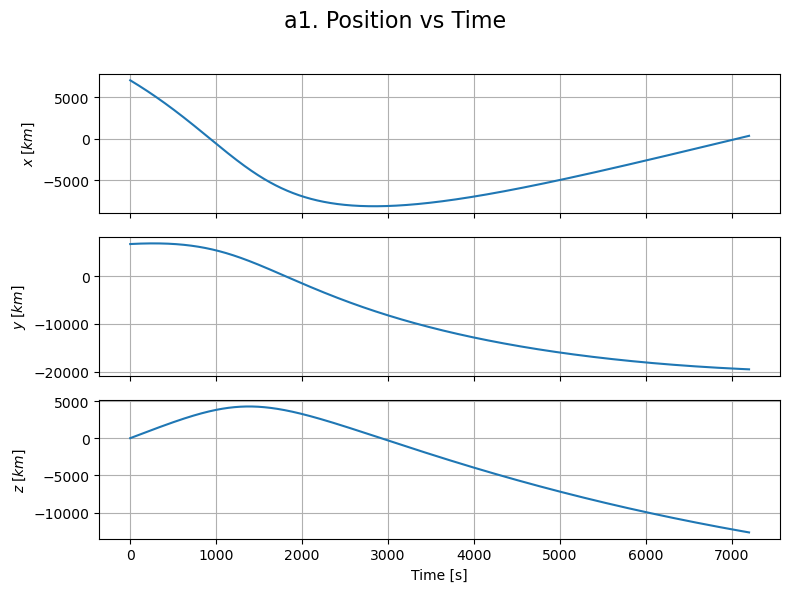

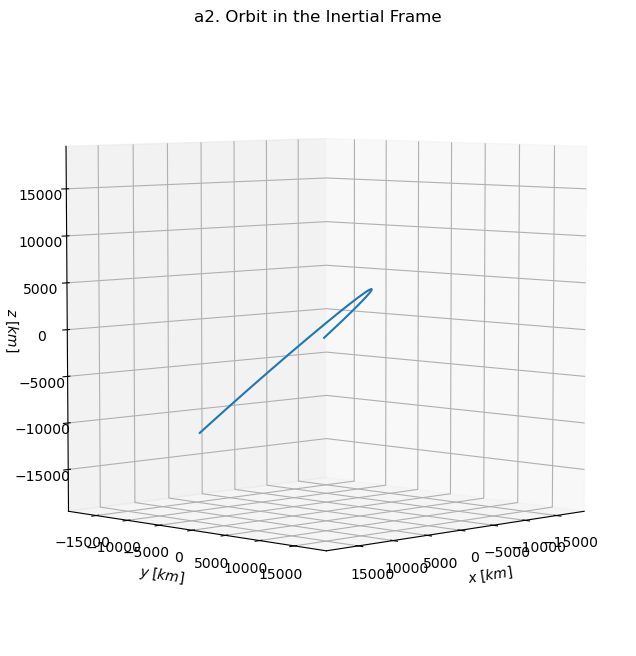

In [3]:
def Translation_EOM(x,t,mu):
    A = -mu/np.linalg.norm(x[:3])**3
    return np.array([[0,0,0,1,0,0],
                     [0,0,0,0,1,0],
                     [0,0,0,0,0,1],
                     [A,0,0,0,0,0],
                     [0,A,0,0,0,0],
                     [0,0,A,0,0,0]])@x

xECI = odeint(Translation_EOM,xECI_0,times,rtol=tol,atol=tol,args=(mu,))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for i, label in enumerate(["x","y","z"]):
    axes[i].plot(times, xECI[:,i])
    axes[i].set_ylabel(f"${label}\\;[km]$")
    axes[i].grid()
axes[-1].set_xlabel("Time [s]")
fig.suptitle("a1. Position vs Time",fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xECI[:, 0], xECI[:, 1], xECI[:, 2])
ax.set_box_aspect([1, 1, 1])
ax.set_xlabel('$x\\;[km]$')
ax.set_ylabel('$y\\;[km]$')
ax.set_zlabel('$z\\;[km]$')
max_val = np.max(np.abs(xECI[:, :3]))
ax.set_xlim([-max_val,max_val])
ax.set_ylim([-max_val,max_val])
ax.set_zlim([-max_val,max_val])
ax.set_title('a2. Orbit in the Inertial Frame')
ax.view_init(elev=5, azim=45)
plt.show()

#### (b) Uncontrolled Attitude Dynamics
Simulate the uncontrolled attitude dynamics of the spacecraft. The coupled differential equations for quaternion and the angular velocity vectors are,

$$
\dot{\mathbf{q}} = \frac{1}{2} \Sigma(\mathbf{q}) \boldsymbol{\omega}
$$

$$
\mathbf{I} \dot{\boldsymbol{\omega}} + \boldsymbol{\omega} \times \mathbf{I} \boldsymbol{\omega} = \mathbf{L}_{s/w}
$$

where $\mathbf{L}_{s/w}$ is the torque on the spacecraft due to the reaction wheels. 

Note: To simulate the uncontrolled dynamics, you can disable the reaction wheel control by setting the control gains $k_p = k_d = 0$.

Deliverables:
1. Plot the time histories of the quaternion vector components.
2. Plot the time histories of the angular velocities vector components.

In [4]:
def A(q):
    return np.array([[ q[3], -q[2],  q[1]],
                     [ q[2],  q[3], -q[0]],
                     [-q[1],  q[0],  q[3]],
                     [-q[0], -q[1], -q[2]]])

def L_REACTION_WHEELS_TO_SC_Func(q,w,kp,kd):
    dq = np.zeros(4)
    dq[:3] = A(qc).T@q
    dq[3] = qc.T@q
    dw = w-wc
    return -kp*np.sign(dq[3])*dq[:3]-kd*dw

def Rotational_EOM(x,t,kp=kp,kd=kd):
    q = x[:4]
    w = x[4:7]
    hw = x[7:]
    dq = 0.5*A(q)@w
    L_REACTION_WHEELS_TO_SC = L_REACTION_WHEELS_TO_SC_Func(q,w,kp,kd)
    dw = I_body_INV@(L_REACTION_WHEELS_TO_SC-np.cross(w,I_body@w))
    L_SC_TO_REACTION_WHEELS = -L_REACTION_WHEELS_TO_SC
    dhw = L_SC_TO_REACTION_WHEELS-np.cross(w,hw)
    return [dq[0],
            dq[1],
            dq[2],
            dq[3],
            dw[0],
            dw[1],
            dw[2],
            dhw[0],
            dhw[1],
            dhw[2]]

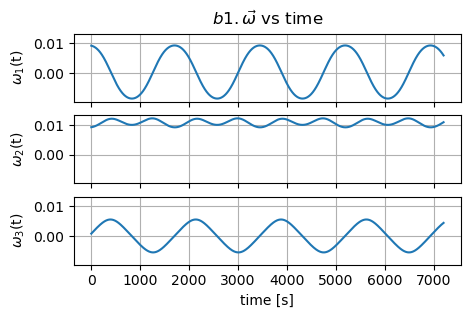

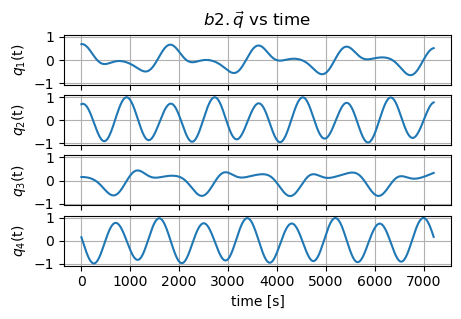

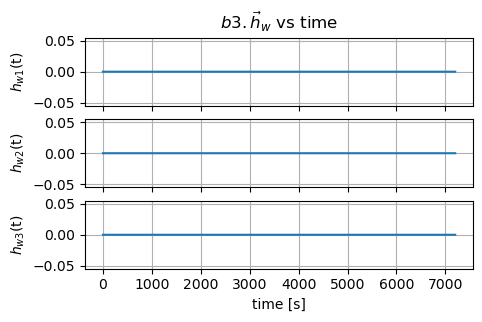

In [5]:
xROT = odeint(Rotational_EOM,xROT_0,times,rtol=tol,atol=tol,args=(0,0)).T
q = xROT[:4]
w = xROT[4:7]
hw = xROT[7:]

fig,axes = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$b1. \vec{\omega}\text{ vs time}$")
for idx,var_name in enumerate([r"$\omega_1$",
                                r"$\omega_2$",
                                r"$\omega_3$"]):
    axes[idx].plot(times,w[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

fig,axes = plt.subplots(4,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$b2. \vec{q}\text{ vs time}$")
for idx,var_name in enumerate([r"$q_1$",
                                r"$q_2$",
                                r"$q_3$",
                                r"$q_4$"]):
    axes[idx].plot(times,q[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

fig,axes = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$b3. \vec{h}_w\text{ vs time}$")
for idx,var_name in enumerate([r"$h_{w1}$",
                                r"$h_{w2}$",
                                r"$h_{w3}$"]):
    axes[idx].plot(times,hw[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

#### (c) Controlled Attitude Dynamics
Simulate the controlled attitude dynamics of the spacecraft by integrating the same set of equations as in the previous problem, but with the control gains enabled.

Additionally, while the control torque on the spacecraft due to the reaction wheels is $\mathbf{L}_{s/w}$, the reaction wheels experience an equal and opposite torque, 
$$
\mathbf{L}_w = -\mathbf{L}_{s/w}.
$$

Thus, the governing differential equation for the wheel angular momentum is, 
$$
\dot{\mathbf{h}}_w + \boldsymbol{\omega} \times \mathbf{h}_w = \mathbf{L}_w.
$$

Deliverables:
1. Plot the time histories of the controlled quaternion vector components.
2. Plot the time histories of the controlled angular velocities.
3. Plot the time histories of the wheel angular momentum vector components.

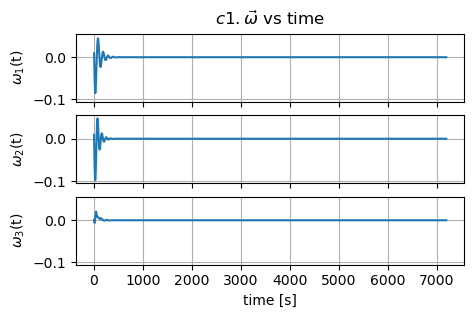

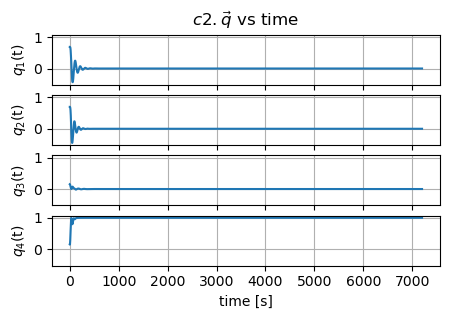

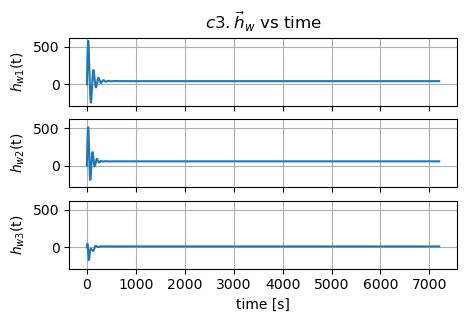

In [6]:
xROT = odeint(Rotational_EOM,xROT_0,times,rtol=tol,atol=tol).T
q = xROT[:4]
w = xROT[4:7]
hw = xROT[7:]

fig,axes = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$c1. \vec{\omega}\text{ vs time}$")
for idx,var_name in enumerate([r"$\omega_1$",
                                r"$\omega_2$",
                                r"$\omega_3$"]):
    axes[idx].plot(times,w[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

fig,axes = plt.subplots(4,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$c2. \vec{q}\text{ vs time}$")
for idx,var_name in enumerate([r"$q_1$",
                                r"$q_2 $",
                                r"$q_3$",
                                r"$q_4$"]):
    axes[idx].plot(times,q[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

fig,axes = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$c3. \vec{h}_w\text{ vs time}$")
for idx,var_name in enumerate([r"$h_{w1}$",
                                r"$h_{w2}$",
                                r"$h_{w3}$"]):
    axes[idx].plot(times,hw[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

#### (d) Specific Values
At time $t^* = 10$ mins, determine the numerical values of the following vectors:

1. $q(t^*)$ =?
2. $\omega(t^*)$ =?
3. $h_w(t^*)$ =?

Additionally, provide your observations. Was the spacecraft’s re-orientation
maneuver successful?

In [7]:
t_star = 10*60
idx = np.where(times==t_star)[0]
q_star = q[:,idx]
w_star = w[:,idx]
hw_star = hw[:,idx]

displayH(sy.Symbol(r"d1.\; q(t^{*})="),sy.Matrix(q_star))
displayH(sy.Symbol(r"d2.\; \omega(t^{*})="),sy.Matrix(w_star),sy.Symbol(r"\left[\frac{rad}{s}\right]"))
displayH(sy.Symbol(r"d3.\; h_w(t^{*})="),sy.Matrix(hw_star),sy.Symbol(r"\left[\frac{kg \cdot m^2}{s}\right]"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

From these values, we can see that the spacecraft's reorientation maneuver was essentially completed, the angular velocity vector is very close to zero, and the quaternion is basically at the commanded values.

## 2. Momentum dumping using magnetic torquers
Once the reorientation maneuver is completed, the spacecraft comes to a complete stop with zero angular velocity. However, the reaction wheels may still be spinning, retaining angular momentum. In the momentum dumping operation mode, the objective is to eliminate the angular momentum of the reaction wheels and ultimately bring the total angular momentum of the spacecraft and reaction wheel system to zero. To achieve this, the onboard magnetic torquers are employed. Continuing from the previous simulation, assume that the magnetic torquers are activated at time $t^* = 10$ mins. The following magnetic torquer control law needs to be tested:

$$
\mathbf{L}_{s/m} = −k_m(I_3 − \mathbf{b}\mathbf{b}^T )h_w
$$

where,
- $\mathbf{L}_{s/m}$ = control torque on the spacecraft due to magnetic torquers
- $k_m$ = 0.001, is the control gain for the magnetic torquers
- $I_3$ = is an identity matrix of size 3 × 3
- $h_w$ = is the wheel angular momentum vector
- b = is the unit vector of the local geomagnetic field expressed in body-frame

The vector b can be computed as follows,
$$
b =
\frac{^{body}\{b\}}{||^{body}\{b\}||}
$$
$$
^{body}\{b\} = A(q) ^{eci}\{b\}
$$
$$
\mathbf{A}(\mathbf{q}) = \begin{bmatrix} 
q_1^2 - q_2^2 - q_3^2 + q_4^2 & 2(q_1q_2 + q_3q_4) & 2(q_1q_3 - q_2q_4) \\
2(q_1q_2 - q_3q_4) & -q_1^2 + q_2^2 - q_3^2 + q_4^2 & 2(q_2q_3 + q_1q_4) \\
2(q_1q_3 + q_2q_4) & 2(q_2q_3 - q_1q_4) & -q_1^2 - q_2^2 + q_3^2 + q_4^2 
\end{bmatrix}
$$
where, A(q) is the attitude matrix or the direction cosine matrix that transforms vectors from the ECI frame to the body-frame. During mission operations, the local geomagnetic field vector in the ECI frame, $^{body}\{b\}$, is determined using the spacecraft’s current ECI position vector and the on board International Geomagnetic Reference Field (IGRF) model. For our analysis, these vectors are provided in the Excel file “bvec ECI rec.xlsx”, which contains a matrix of size 3 × 1441. Each column of the matrix represents a vector, $^{eci}\{b\}$,
corresponding to times t = (0, 5 sec, 10 sec, . . . , 2 hrs) as the spacecraft orbits the Earth. The unit of the geomagnetic field vector is Tesla.

Perform the following tasks:

#### (a) Desaturation
Simulate the controlled attitude dynamics of the spacecraft with reaction wheels and magnetic torquers using the following equations,
$$
\dot{q} = \frac{1}{2}\sum(q)\omega
$$
$$
I\dot{\omega}+\omega \times I \omega=\mathbf{L}_{s/w}+\mathbf{L}_{s/m}
$$
In this equation, only the reaction wheel control torque, Ls/w, is active during the time interval [t0, t∗] for the re-orientation maneuver. After the maneuver is completed, both controllers are active for the remaining time interval [t∗, tf ] during momentum dumping.
Deliverables:
1. Re-plot the time histories of the components of the reaction wheel angular
momentum vector.
2. How do the wheel angular momenta in this problem, with active magnetic
torquers, differ from those in the previous problem

In [8]:
xROT_star = np.vstack([q_star,w_star,hw_star])[:,0]

times = np.arange(0,tf+0.1,5)
b_eci = pd.read_csv("bvec_ECI_rec.csv",header=None).T.to_numpy()
b_eci_func = interp1d(times,b_eci.T,bounds_error=False,fill_value=(b_eci[0],b_eci[-1]))

In [9]:
def Quat_to_DCM(q):
    q_1 = q[0]
    q_2 = q[1]
    q_3 = q[2]
    q_4 = q[3]

    return np.array([[q_1**2 - q_2**2 - q_3**2 + q_4**2, 2*(q_1*q_2 + q_3*q_4), 2*(q_1*q_3 - q_2*q_4)],
                     [2*(q_1*q_2 - q_3*q_4), -q_1**2 + q_2**2 - q_3**2 + q_4**2, 2*(q_2*q_3 + q_1*q_4)],
                     [2*(q_1*q_3 + q_2*q_4), 2*(q_2*q_3 - q_1*q_4), -q_1**2 - q_2**2 + q_3**2 + q_4**2]])
    
def b_body_func(q,t):
    return Quat_to_DCM(q)@b_eci_func(t)

def L_MAGNETORQUER_TO_SC_Func(b,hw,km):
    return -km*(np.eye(3)-np.outer(b,b))@hw

def Rotational_EOM_MAGNETORQUER(x,t,kp=kp,kd=kd,km=km):
    q = x[:4]
    w = x[4:7]
    hw = x[7:]
    dq = 0.5*A(q)@w
    
    b_body = b_body_func(q,t)
    b_body_mag = np.linalg.norm(b_body)
    if b_body_mag > 0:
        b_body_norm = b_body/b_body_mag
    else:
        b_body_norm = 0
        
    L_REACTION_WHEELS_TO_SC = L_REACTION_WHEELS_TO_SC_Func(q,w,kp,kd)
    
    if t >= t_star:
        L_MAGNETORQUER_TO_SC = L_MAGNETORQUER_TO_SC_Func(b_body,hw,km)
    else:
        L_MAGNETORQUER_TO_SC = 0
        
    dw = I_body_INV@(L_REACTION_WHEELS_TO_SC+L_MAGNETORQUER_TO_SC-np.cross(w,I_body@w))
    L_SC_TO_REACTION_WHEELS = -L_REACTION_WHEELS_TO_SC
    dhw = L_SC_TO_REACTION_WHEELS-np.cross(w,hw)
    return [dq[0],
            dq[1],
            dq[2],
            dq[3],
            dw[0],
            dw[1],
            dw[2],
            dhw[0],
            dhw[1],
            dhw[2]]

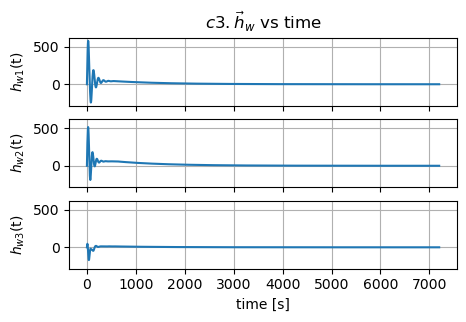

In [10]:
xROT = odeint(Rotational_EOM_MAGNETORQUER,xROT_0,times,rtol=tol,atol=tol,args=(kp,kd,km)).T
q = xROT[:4]
w = xROT[4:7]
hw = xROT[7:]

fig,axes = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$c3. \vec{h}_w\text{ vs time}$")
for idx,var_name in enumerate([r"$h_{w1}$",
                                r"$h_{w2}$",
                                r"$h_{w3}$"]):
    axes[idx].plot(times,hw[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

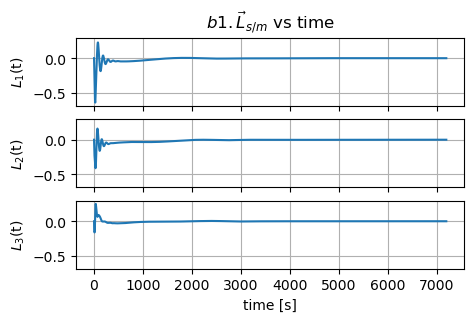

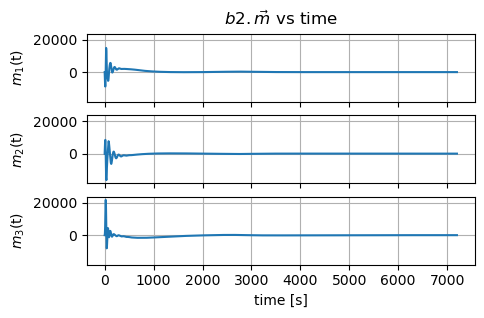

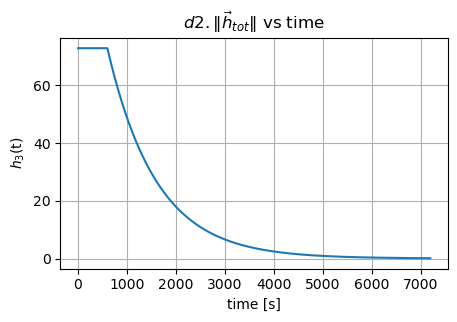

In [ ]:
b_body = np.array([b_body_func(quat,t) for quat,t in zip(q.T,times)])
b_body_mag = np.linalg.norm(b_body,axis=1)
b_body_mag[b_body_mag<1e-15]=0
b_body_norm = np.array([b/bmag if bmag != 0 else np.zeros(3) for b,bmag in zip(b_body,b_body_mag)])

L_MAGNETORQUER_TO_SC = np.array([L_MAGNETORQUER_TO_SC_Func(b,h,km) for b,h in zip(b_body_norm,hw.T)]).T
COMMANDED_DIPOLE = np.array([km*np.cross(h,b)/bmag if bmag !=0 else np.zeros(3) for h,b,bmag in zip(hw.T,b_body_norm,b_body_mag)]).T

h_tot = np.array([h+I_body@omega for omega,h in zip(w.T,hw.T)]).T

fig,axes = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$b1. \vec{L}_{s/m}\text{ vs time}$")
for idx,var_name in enumerate([r"$L_{1}$",
                                r"$L_{2}$",
                                r"$L_{3}$"]):
    axes[idx].plot(times,L_MAGNETORQUER_TO_SC[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

fig,axes = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$b2. \vec{m}\text{ vs time}$")
for idx,var_name in enumerate([r"$m_{1}$",
                                r"$m_{2}$",
                                r"$m_{3}$"]):
    axes[idx].plot(times,COMMANDED_DIPOLE[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

fig,axes = plt.subplots(1,sharex=True,sharey=True,figsize=(5,3))
axes.set_title(r"$d2. \|\vec{h}_{tot}\|\text{ vs time}$")
axes.plot(times,np.linalg.norm(h_tot,axis=0))
axes.set_ylabel(r"$h_{3}$"+"(t)")
axes.grid()
axes.set_xlabel("time [s]")
plt.show()

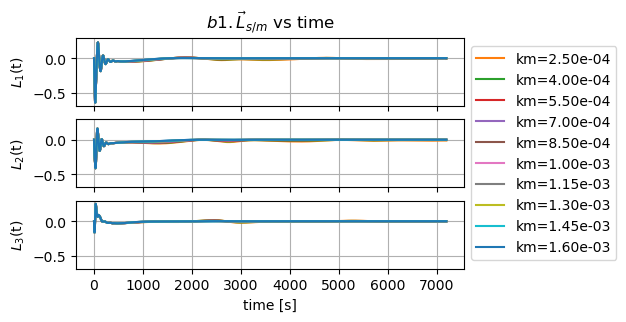

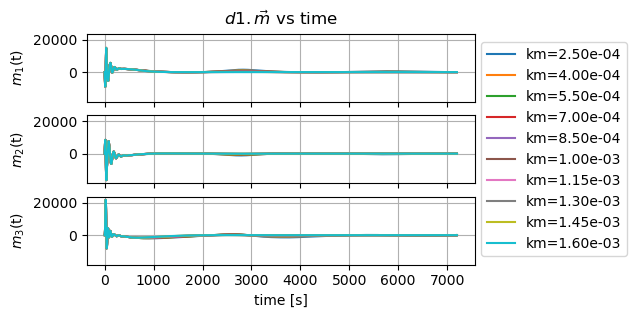

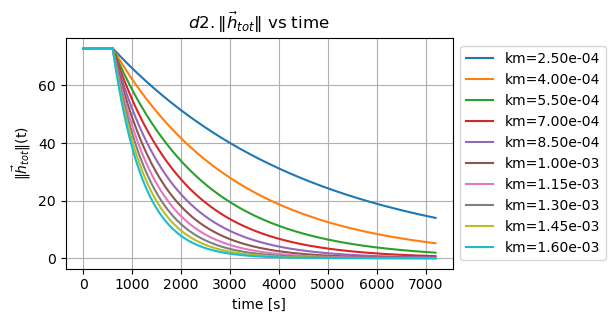

In [16]:
fig3,axes3 = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes3[0].set_title(r"$b1. \vec{L}_{s/m}\text{ vs time}$")
axes3[-1].set_xlabel("time [s]")

fig1,axes1 = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes1[0].set_title(r"$d1. \vec{m}\text{ vs time}$")
axes1[-1].set_xlabel("time [s]")

fig2,axes2 = plt.subplots(1,sharex=True,sharey=True,figsize=(5,3))
axes2.set_title(r"$d2. \|\vec{h}_{tot}\|\text{ vs time}$")
axes2.set_ylabel(r"$\|\vec{h}_{tot}\|$"+"(t)")
axes2.set_xlabel("time [s]")
axes2.grid()

for idx,var_name in enumerate([r"$m_{1}$",
                                r"$m_{2}$",
                                r"$m_{3}$"]):
    axes1[idx].set_ylabel(var_name+"(t)")
    axes1[idx].grid()
    
for idx,var_name in enumerate([r"$L_{1}$",
                                r"$L_{2}$",
                                r"$L_{3}$"]):
    axes3[idx].plot(times,L_sm[idx])
    axes3[idx].set_ylabel(var_name+"(t)")
    axes3[idx].grid()

step = 10**(np.log10(km)-1)*1.5
N_steps = 5
for val in np.arange(km-step*N_steps,step*N_steps+km,step):

    xROT = odeint(Rotational_EOM_MAGNETORQUER,xROT_0,times,rtol=tol,atol=tol,args=(kp,kd,val)).T
    q = xROT[:4]
    w = xROT[4:7]
    hw = xROT[7:]

    b_body = np.array([b_body_func(quat,t) for quat,t in zip(q.T,times)])
    b_body_mag = np.linalg.norm(b_body,axis=1)
    b_body_mag[b_body_mag<1e-15]=0
    b_body_norm = np.array([b/bmag if bmag != 0 else np.zeros(3) for b,bmag in zip(b_body,b_body_mag)])

    L_MAGNETORQUER_TO_SC = np.array([L_MAGNETORQUER_TO_SC_Func(b,h,km) for b,h in zip(b_body_norm,hw.T)]).T
    COMMANDED_DIPOLE = np.array([km*np.cross(h,b)/bmag if bmag !=0 else np.zeros(3) for h,b,bmag in zip(hw.T,b_body_norm,b_body_mag)]).T

    h_tot = np.array([h+I_body@omega for omega,h in zip(w.T,hw.T)]).T
    
    for idx in range(3):
        axes1[idx].plot(times,COMMANDED_DIPOLE[idx],label=f"km={val:.2e}")
        axes3[idx].plot(times,L_MAGNETORQUER_TO_SC[idx],label=f"km={val:.2e}")
    axes2.plot(times,np.linalg.norm(h_tot,axis=0),label=f"km={val:.2e}")

axes1[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes3[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [17]:
kD = 10

q0 = 1/(2)**0.5*np.array([1,0,0,1])
w0 = np.array([0.01,0.01,0.01])

xROT_0_DETUMBLING = np.hstack([q0,w0])

def L_DETUMBLING_Func(b,w,kD):
    return -kD*(np.eye(3)-np.outer(b,b))@w

def Rotational_EOM_DETUMBLING(x,t,kD=kD):
    q = x[:4]
    w = x[4:7]
    
    dq = 0.5*A(q)@w
    
    b_body = b_body_func(q,t)
    b_body_mag = np.linalg.norm(b_body)
    if b_body_mag > 0:
        b_body_norm = b_body/b_body_mag
    else:
        b_body_norm = 0
        
    L_DETUMBLING = L_DETUMBLING_Func(b_body_norm,w,kD)
        
    dw = I_body_INV@(L_DETUMBLING-np.cross(w,I_body@w))
    return [dq[0],
            dq[1],
            dq[2],
            dq[3],
            dw[0],
            dw[1],
            dw[2]]

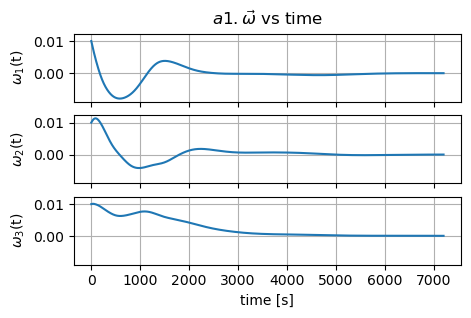

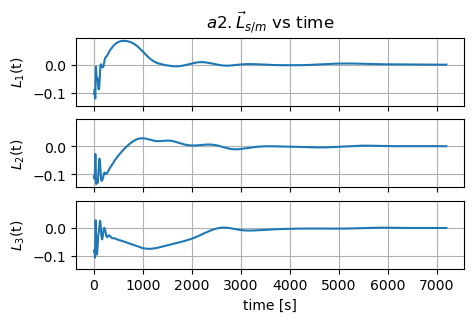

In [18]:
xROT = odeint(Rotational_EOM_DETUMBLING,xROT_0_DETUMBLING,times,rtol=tol,atol=tol).T
q = xROT[:4]
w = xROT[4:7]

L_DETUMBLING = np.array([L_DETUMBLING_Func(b,omega,kD) for b,omega in zip(b_body_norm,w.T)]).T

fig,axes = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$a1. \vec{\omega}\text{ vs time}$")
for idx,var_name in enumerate([r"$\omega_1$",
                                r"$\omega_2$",
                                r"$\omega_3$"]):
    axes[idx].plot(times,w[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

fig,axes = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes[0].set_title(r"$a2. \vec{L}_{s/m}\text{ vs time}$")
for idx,var_name in enumerate([r"$L_{1}$",
                                r"$L_{2}$",
                                r"$L_{3}$"]):
    axes[idx].plot(times,L_DETUMBLING[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

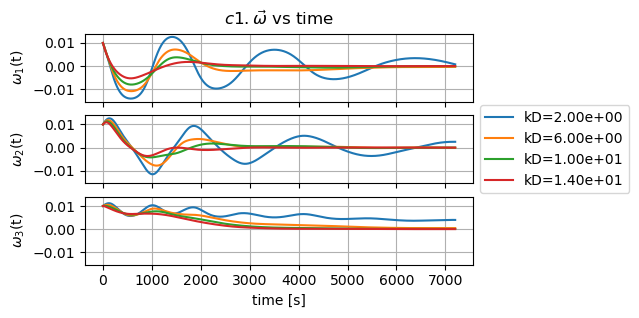

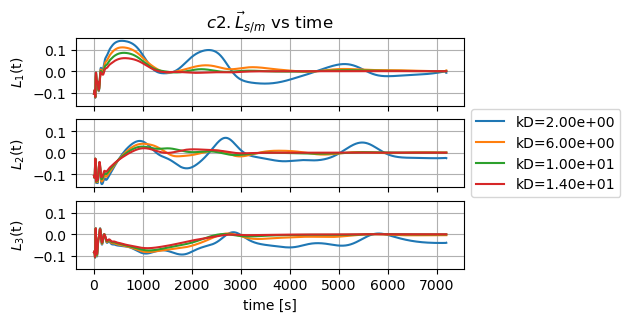

In [24]:
fig1,axes1 = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes1[0].set_title(r"$c1. \vec{\omega}\text{ vs time}$")
axes1[-1].set_xlabel("time [s]")

fig2,axes2 = plt.subplots(3,sharex=True,sharey=True,figsize=(5,3))
axes2[0].set_title(r"$c2. \vec{L}_{s/m}\text{ vs time}$")
axes2[-1].set_xlabel("time [s]")

for idx,var_name in enumerate([r"$\omega_1$",
                                    r"$\omega_2$",
                                    r"$\omega_3$"]):
    axes1[idx].set_ylabel(var_name+"(t)")
    axes1[idx].grid()
    
for idx,var_name in enumerate([r"$L_{1}$",
                                r"$L_{2}$",
                                r"$L_{3}$"]):
    axes2[idx].set_ylabel(var_name+"(t)")
    axes2[idx].grid()

step = 10**(np.log10(kD)-1)*4
N_steps = 2
for val in np.arange(kD-step*N_steps,step*N_steps+kD,step):

    xROT = odeint(Rotational_EOM_DETUMBLING,xROT_0_DETUMBLING,times,rtol=tol,atol=tol,args=(val,)).T
    q = xROT[:4]
    w = xROT[4:7]

    L_DETUMBLING = np.array([L_DETUMBLING_Func(b,omega,kD) for b,omega in zip(b_body_norm,w.T)]).T

    
    for idx in range(3):
        axes1[idx].plot(times,w[idx],label=f"kD={val:.2e}")
        axes2[idx].plot(times,L_DETUMBLING[idx],label=f"kD={val:.2e}")

axes1[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes2[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()